# Benchmark 

In [1]:
%load_ext autoreload
%autoreload 2


In [57]:
import os
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [7]:
proj_name = "pbmc_DeSimone_10K"
file_suffix = time.strftime('%b%d-%H%M')

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

seed = 0
ccd.ul.set_seed(seed)

In [69]:
# load the data
adata = sc.read_h5ad(data_dir / "template_pbmc_10K.h5ad")

In [70]:
batch_key = 'dataset'
state_key = 'cell_type'

# preprocess the data
# HVG selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="dataset")

# Make sure counts are stored
if adata.raw is not None:
    raw_X = adata.raw[:, adata.var_names].X
    dense_X = raw_X.toarray() if sparse.issparse(raw_X) else raw_X

    if np.allclose(dense_X, np.round(dense_X)):
        adata.layers["counts"] = raw_X.astype(np.int32)
        print("✅ counts layer set from adata.raw (converted to int32)")
    else:
        raise ValueError("❌ adata.raw.X contains non-integer-like values.")
else:
    raise ValueError("❌ adata.raw is None — cannot set counts layer.")

# Subset to HVGs
adata = adata[:, adata.var.highly_variable].copy()

# PCA
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)


✅ counts layer set from adata.raw (converted to int32)


In [21]:
# create jobs for integration methods

proj_name = 'pbmc_DeSimone_10K'
adata_filename = 'template_pbmc_10K.h5ad'
methods = 'concord scvi harmony scanorama liger unintegrated'
batch_key = 'dataset'
state_key = 'cell_type'
output_dir = '../jobs'
device = 'auto'
conda_env = 'scenv'
# mem = '16G'; scratch = '100G'; runtime = '02:00:00'; 

!python generate_py_sh_jobs.py \
  --proj_name {proj_name} \
  --adata_filename {adata_filename} \
  --methods {methods} \
  --batch_key {batch_key} \
  --state_key {state_key} \
  --output_dir {output_dir} \
  --device {device}

✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_concord.py
✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_concord.sh

✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_scvi.py
✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_scvi.sh

✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_harmony.py
✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_harmony.sh

✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_scanorama.py
✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_scanorama.sh

✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_liger.py
✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_liger.sh

✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_unintegrated.py
✅ Generated: benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_unintegrated.sh



In [74]:
# methods = 'harmony scanorama liger unintegrated'
methods = 'scvi liger'

In [75]:
job_dir = Path(output_dir) / f"benchmark_{proj_name}"

method_list = methods.strip().split()

for method in method_list:
    sh_path = job_dir / f"benchmark_{proj_name}_{method}.sh"
    if sh_path.exists():
        print(f"✅ Submitting: {sh_path}")
        os.system(f"sh {sh_path}")
    else:
        print(f"⚠️  Skipped: {sh_path} not found")

✅ Submitting: ../jobs/benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_scvi.sh
Running on: pgpudev1.wynton.ucsf.edu
index, name, memory.total [MiB], driver_version
0, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
1, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
2, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
3, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05


/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-06-17 02:55:02,305 - INFO - Using device: cuda
2025-06-17 02:55:02,328 - INFO - Using GPU 0: NVIDIA GeForce GTX 1080
2025-06-17 02:55:02,336 - INFO - Logging to: ../../save/pbmc_DeSimone_10K/scvi_0617-0254/run.log
2025-06-17 02:55:02,337 - INFO - Starting integration pipeline...
2025-06-17 02:55:04,971 - INFO - Loaded AnnData from: ../../data/pbmc_DeSimone_10K/template_pbmc_10K.h5ad
2025-06-17 02:55:15,839 - INFO - ❌ scvi failed: counts is not a valid key in adata.layers.
2025-06-17 02:55:15,839 - INFO - ✅ Selected methods completed.
2025-06-17 02:55:15,840 - INFO - Integration co

✅ Submitting: ../jobs/benchmark_pbmc_DeSimone_10K/benchmark_pbmc_DeSimone_10K_liger.sh
Running on: pgpudev1.wynton.ucsf.edu
index, name, memory.total [MiB], driver_version
0, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
1, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
2, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05
3, NVIDIA GeForce GTX 1080, 8192 MiB, 550.127.05


/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-06-17 02:55:29,807 - INFO - Using device: cuda
2025-06-17 02:55:29,826 - INFO - Using GPU 0: NVIDIA GeForce GTX 1080
2025-06-17 02:55:29,833 - INFO - Logging to: ../../save/pbmc_DeSimone_10K/liger_0617-0255/run.log
2025-06-17 02:55:29,835 - INFO - Starting integration pipeline...
2025-06-17 02:55:32,435 - INFO - Loaded AnnData from: ../../data/pbmc_DeSimone_10K/template_pbmc_10K.h5ad
2025-06-17 02:55:43,444 - INFO - /wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled ar

In [ ]:
method_list = ['scvi']

In [28]:
# map the obsm back to the adata 
# for each method, uses the most recent run (based on timestamp)
from benchmark_utils import add_embeddings

adata = add_embeddings(adata, proj_name=proj_name, methods=method_list)



✅ obsm['X_harmony'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['harmony_UMAP']
✅ obsm['harmony_UMAP'] computed


In [35]:
# use scib-metrics to evaluate the embeddings
from benchmark_utils import run_scib_benchmark

embedding_keys = [f"X_{m}" for m in method_list]
bm = run_scib_benchmark(
    adata=adata,
    embedding_keys=embedding_keys, 
    batch_key=batch_key, # batch
    label_key=state_key, # label
    n_jobs=4
)

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]WARNING:2025-06-17 02:01:59,737:jax._src.xla_bridge:791: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     10 clusters consist of a single batch or are too small. Skip.          


Embeddings: 100%|██████████| 1/1 [00:13<00:00, 13.26s/it]


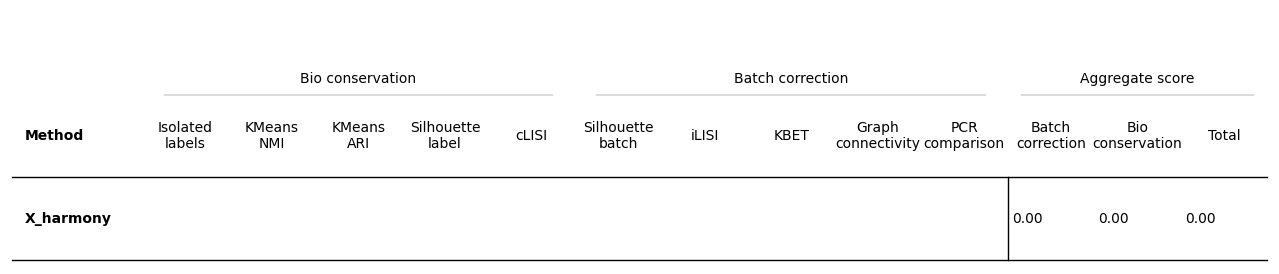

In [36]:
bm.plot_results_table()

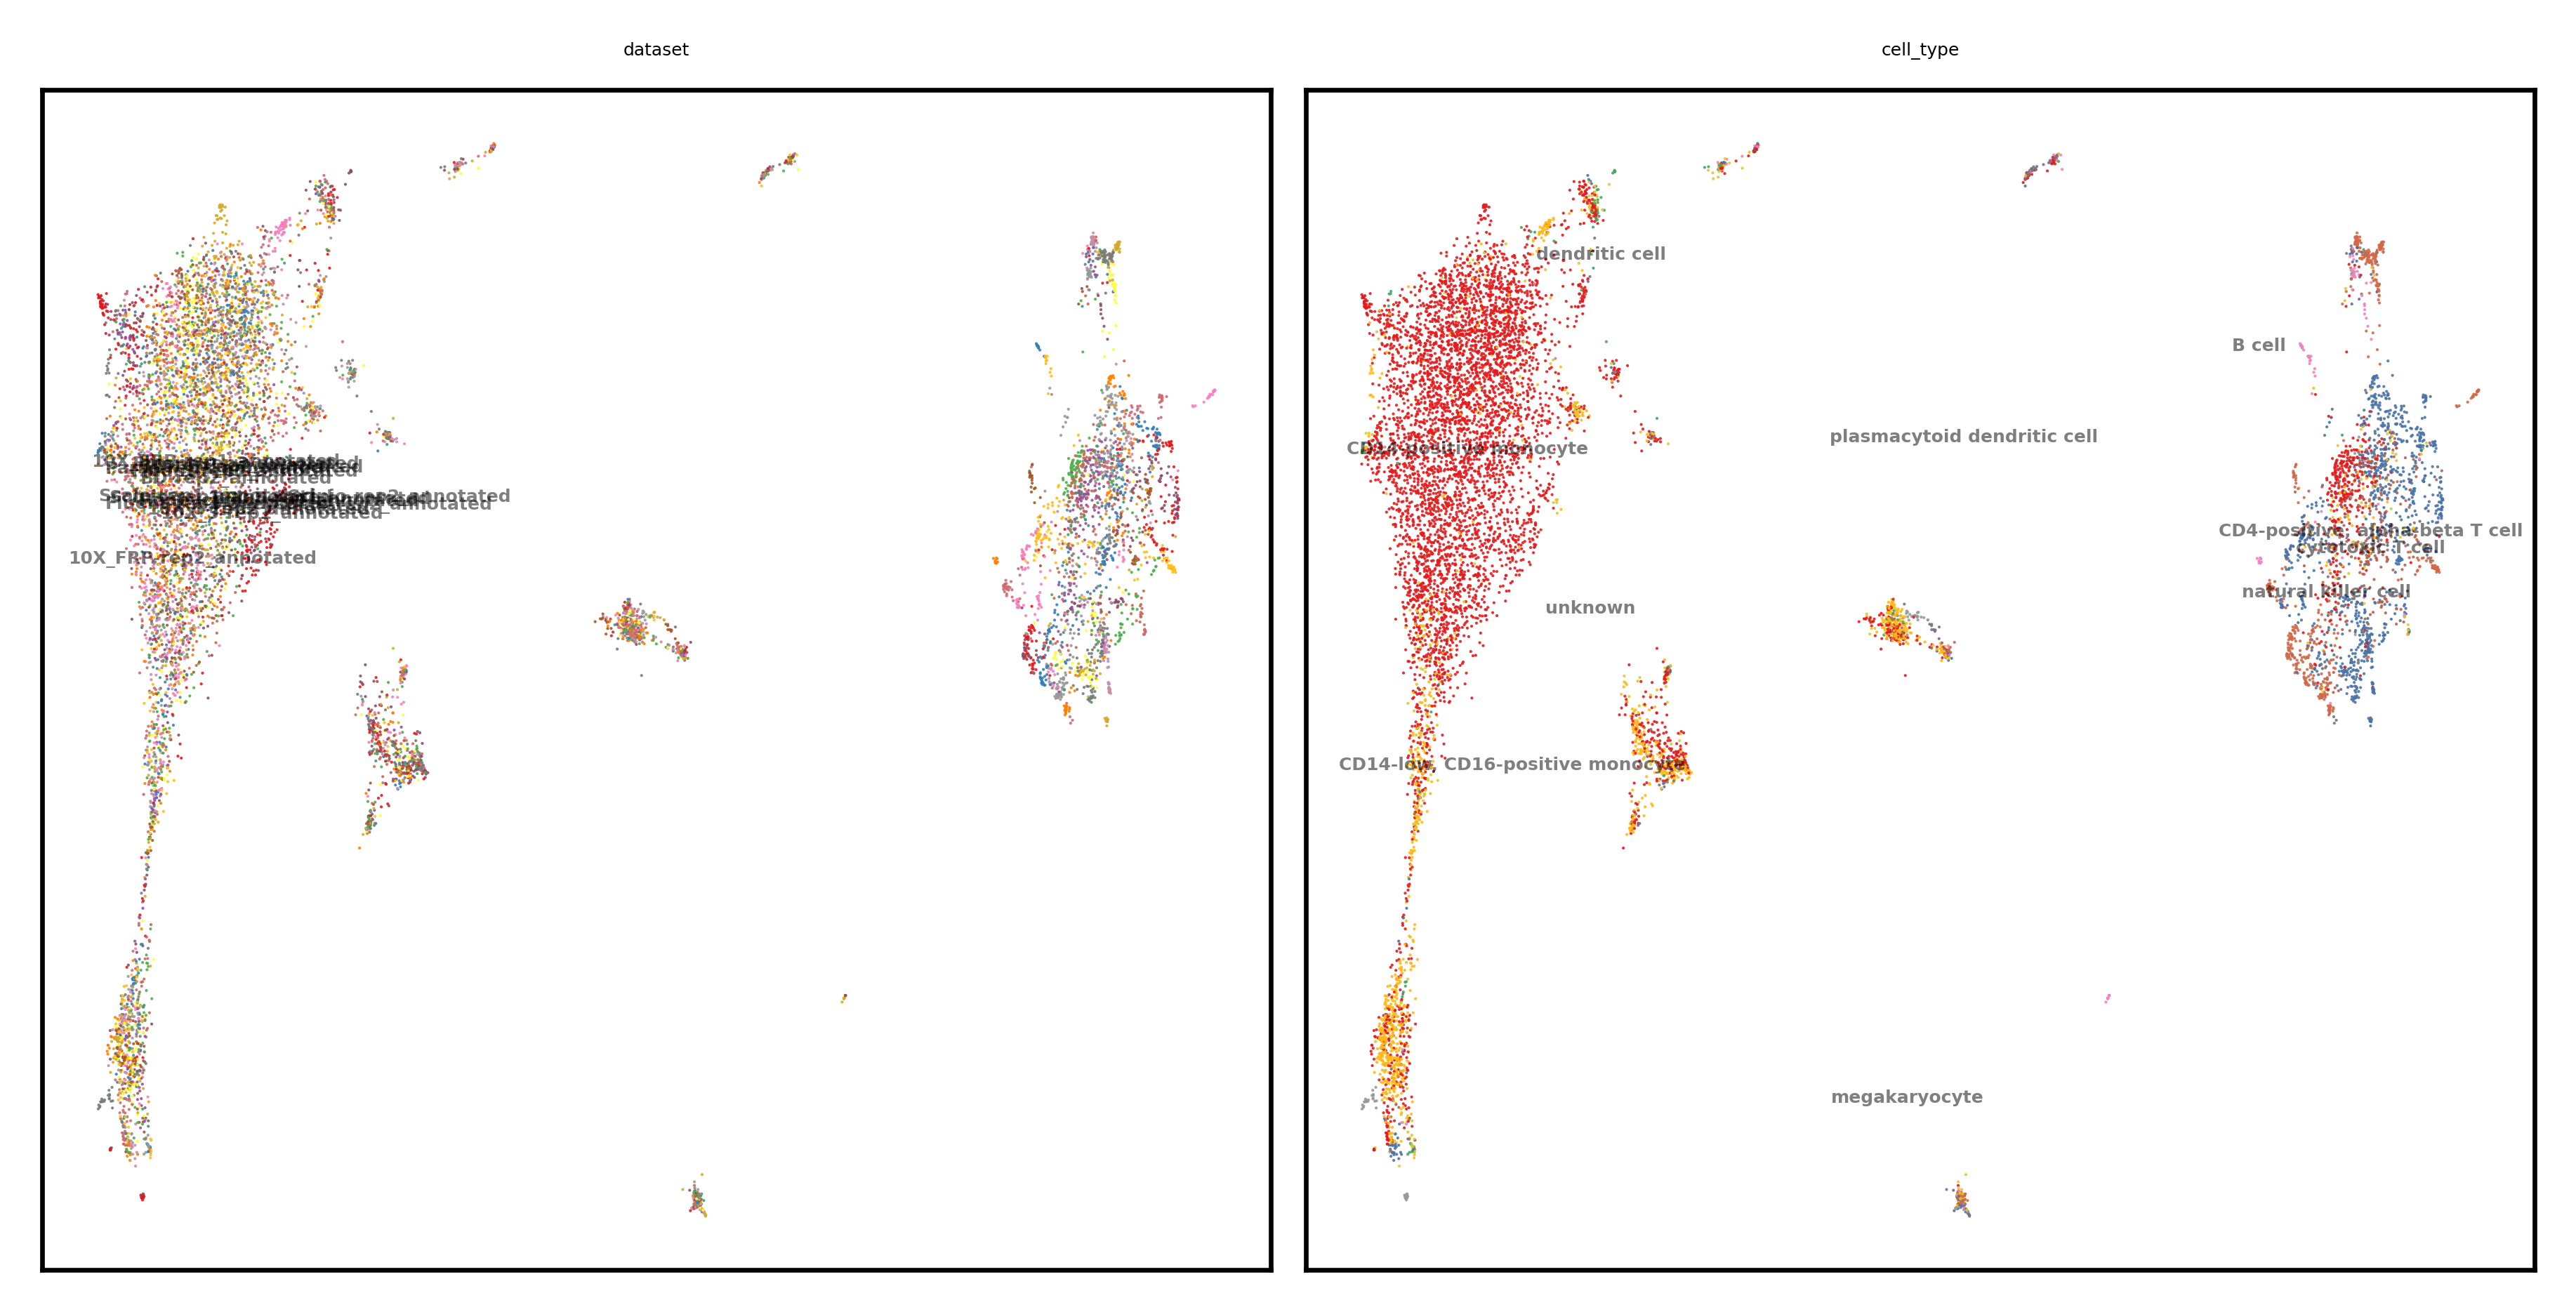

In [30]:
show_emb = 'harmony_UMAP'
# 'concord_UMAP', 'unintegrated_UMAP', 'scanorama_UMAP', 'liger_UMAP', 'harmony_UMAP', 'scvi_UMAP',

show_cols = [batch_key, state_key] # e.g., batch_key is 'dataset', state_key is 'cell_type'

ccd.pl.plot_embedding(
    adata, show_emb, show_cols, 
    figsize=(6,3), dpi=600, ncols=len(show_cols), font_size=3, point_size=1, legend_loc='on data',
    # save_path=save_dir / f"embeddings_{show_emb}_{file_suffix}.pdf"
)

# concord pipeline test

In [77]:
ccd.ul.run_scvi(
    adata, 
    batch_key=batch_key, 
)

INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_

Epoch 400/400: 100%|██████████| 400/400 [04:59<00:00,  1.34it/s, v_num=1, train_loss_step=185, train_loss_epoch=192]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:59<00:00,  1.34it/s, v_num=1, train_loss_step=185, train_loss_epoch=192]


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [76]:
ccd.ul.run_liger(
    adata, 
    batch_key=batch_key, 
)

100%|██████████| 30/30 [02:11<00:00,  4.38s/it]


In [25]:
time_log, ram_log, vram_log = ccd.ul.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=combined_keys,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    device=device,                 # Or "cpu", or "mps" for Apple Silicon
    # latent_dim=30,                        # Latent dimensionality for PCA and embeddings
    # return_corrected=False,                   # Whether to store corrected expression matrices
    # transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    # compute_umap=True,                    # Run UMAP for all output embeddings
    # umap_n_components=2,
    # umap_n_neighbors=30,
    # umap_min_dist=0.1,
    # seed=42,                              # Random seed for reproducibility
    verbose=True,                        # Print progress messages
)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).


KeyboardInterrupt: 

In [18]:
# save the adata object
adata.write_h5ad('../data/pbmc_Darmanis/pbmc_Darmanis_subset_9K.h5ad')